# Model in this notebook

We solve a one-period sovereign debt model with an exogenous sunspot that selects the low- or high-rate schedule. The IMF loan is given by a state-dependent rule `l(g, eps)` at gross rate `R_l`. The government chooses next-period private debt `b'` (via issuance `n`) and can default.

**Repayment value:**

$$
v^{nd}(b,g,s,\epsilon) = \max_{c,n} \left\{ \frac{c^{1-\gamma}}{1-\gamma} + \beta g^{1-\gamma} E\left[\max\{v^{nd}(b',g',s',\epsilon'), v^{d}(b',g',s',\epsilon')\} \mid g,s\right] \right\}\
$$

$$
c + b = y + n + (1-R_l)l(g,\epsilon),\quad g b' = R(n,g,s) n,\quad y = g e^{\sigma\epsilon}.
$$

**Default value:**

$$
v^{d}(b,g,s,\epsilon) = \frac{(\phi(g) y)^{1-\gamma}}{1-\gamma} + \beta g^{1-\gamma} E\left[ \theta v^{d}(b',g',s',\epsilon') + (1-\theta) \max\{v^{nd}(\kappa b',g',s',\epsilon'), v^{d}(b',g',s',\epsilon')\} \mid g,s \right],
$$
$$
g b' = b.
$$

Prices follow `Q(b,g,s,eps) = (1-d) + d X` with `X` defined by the recovery equation, and `R(n,g,s)` is obtained from the pricing schedule.


In [22]:
using LinearAlgebra, Statistics
include("src/structs_s.jl")
include("src/utils_s.jl")
include("src/solver_s.jl")
include("src/simulation_s.jl")


summarize_simulation (generic function with 1 method)

In [23]:
# Initialize model with default parameters and grids
model = init_model()


Model(1000, 2, 2, 15, [-0.05, -0.0493993993993994, -0.048798798798798795, -0.0481981981981982, -0.047597597597597595, -0.046996996996997, -0.046396396396396394, -0.0457957957957958, -0.045195195195195194, -0.0445945945945946  …  0.5445945945945946, 0.5451951951951952, 0.5457957957957958, 0.5463963963963964, 0.546996996996997, 0.5475975975975976, 0.5481981981981981, 0.5487987987987988, 0.5493993993993994, 0.55], [0.96, 1.04], [-2.5, -2.142857142857143, -1.7857142857142858, -1.4285714285714286, -1.0714285714285714, -0.7142857142857143, -0.35714285714285715, 0.0, 0.35714285714285715, 0.7142857142857143, 1.0714285714285714, 1.4285714285714286, 1.7857142857142858, 2.142857142857143, 2.5], [0.6 0.4; 0.25 0.75], [0.010131862501173995, 0.014616621216697082, 0.0292630331680509, 0.05163825678093336, 0.08031706658023353, 0.11011117420737276, 0.1330591008192669, 0.14172576945254356, 0.13305910081926667, 0.11011117420737263, 0.08031706658023344, 0.05163825678093347, 0.029263033168050765, 0.01461662

In [24]:
sol = solve_model(model)
mean(sol.d)


0.15083333333333335

In [25]:
# Diagnostics: iteration counts, errors, and per-iteration timing
println("Outer iterations: ", sol.outer_iters)
println("Final outer error: ", sol.outer_errs[end])

for i in 1:sol.outer_iters
    println("iter=", i,
        ", vnd_err=", sol.outer_errs[i],
        ", vd_err=", sol.vd_errs[i],
        ", x_err=", sol.x_errs[i],
        ", vd_iters=", sol.vd_iters[i],
        ", x_iters=", sol.x_iters[i],
        ", time_s=", sol.outer_times[i])
end


Outer iterations: 16
Final outer error: 4.718920831869866e-7
iter=1, vnd_err=0.48378273425533114, vd_err=3.4496509115911067e-7, x_err=2.96641478603199e-7, vd_iters=7, x_iters=9, time_s=1.9659578800201416
iter=2, vnd_err=0.08824784320676926, vd_err=9.474384388141743e-8, x_err=9.5726693605247e-7, vd_iters=6, x_iters=18, time_s=1.485759973526001
iter=3, vnd_err=0.02874047104225541, vd_err=1.8346381569500636e-7, x_err=5.319075945253715e-7, vd_iters=5, x_iters=9, time_s=1.784188985824585
iter=4, vnd_err=0.008706467414020924, vd_err=7.193017026452253e-8, x_err=3.253411322567956e-7, vd_iters=5, x_iters=7, time_s=0.361828088760376
iter=5, vnd_err=0.002978374866457578, vd_err=5.304964059149597e-7, x_err=1.5782554796395232e-7, vd_iters=4, x_iters=6, time_s=0.27224206924438477
iter=6, vnd_err=0.0012464052580374307, vd_err=2.0214604656842994e-7, x_err=4.96140520556132e-7, vd_iters=4, x_iters=5, time_s=1.3820807933807373
iter=7, vnd_err=0.0005800059614675668, vd_err=8.77657977405022e-8, x_err=4.866

In [26]:
sol = solve_model(model; sol = sol)    # reuse vnd/vd if non-empty
mean(sol.d)

0.15083333333333335

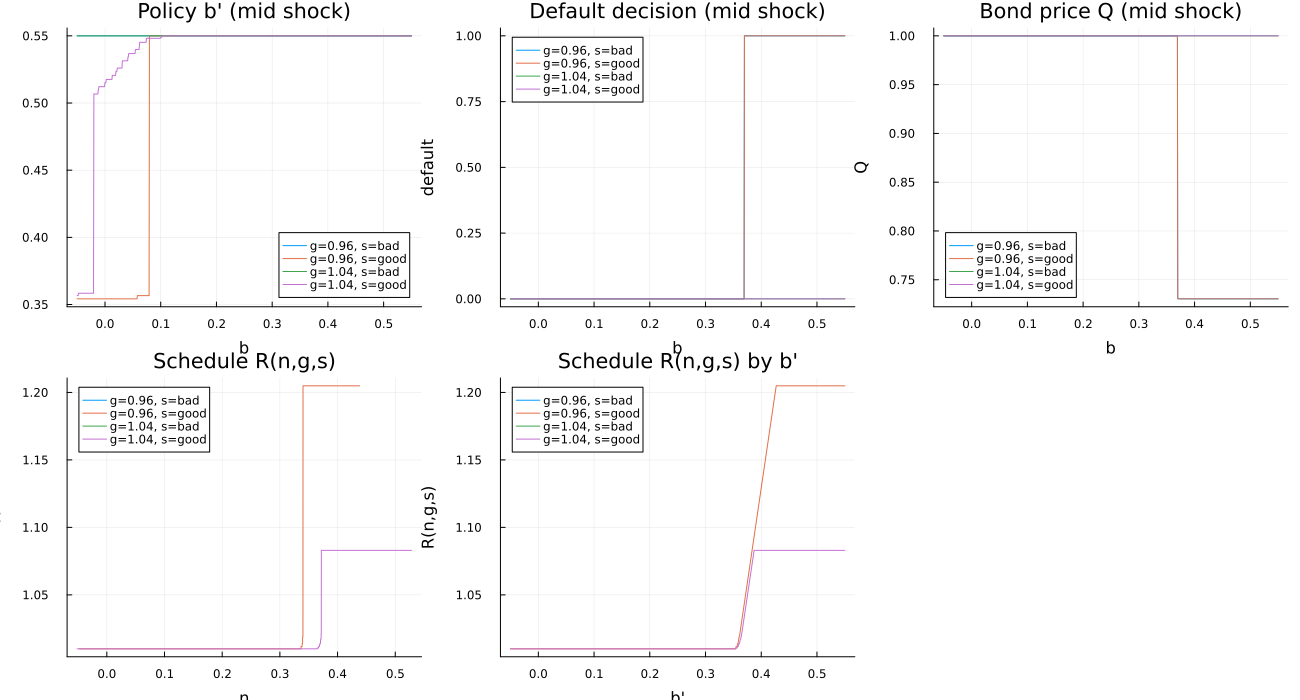

In [32]:
using Plots
b = model.b
g = model.g
eps = model.eps
e_idx = Int(cld(model.Ne, 2))
s_labels = ["bad", "good"]
p1 = plot(title = "Policy b' (mid shock)", xlabel = "b", ylabel = "b'")
p2 = plot(title = "Default decision (mid shock)", xlabel = "b", ylabel = "default")
p3 = plot(title = "Bond price Q (mid shock)", xlabel = "b", ylabel = "Q")
p4 = plot(title = "Schedule R(n,g,s)", xlabel = "n", ylabel = "R")
p5 = plot(title = "Schedule R(n,g,s) by b'", xlabel = "b'", ylabel = "R(n,g,s)")
for gi in 1:model.Ng
    for si in 1:model.Ns
        mask = sol.schedule_mask[:, gi, si]
        bprime_policy = b[sol.b_policy_idx[:, gi, si, e_idx]]
        label = "g=$(g[gi]), s=$(s_labels[si])"
        plot!(p1, b, bprime_policy, label = label)
        plot!(p2, b, Float64.(sol.d[:, gi, si, e_idx]), label = label)
        plot!(p3, b, sol.Q[:, gi, si, e_idx], label = label)
        plot!(p4, sol.n[mask, gi, si], sol.R[mask, gi, si], label = label)
        plot!(p5, b[mask], sol.R[mask, gi, si], label = label)
    end
end
plot(p1, p2, p3, p4, p5, layout = (2, 3), size = (1300, 700))


In [28]:
# Simulation
b0_idx = 1  # pick a savings grid point by index
sim = simulate(model, sol; T = 200_000, b0_idx = b0_idx, seed = 1234)


(b = [-0.05, 0.55, 0.42987987987987986, 0.3355855855855856, 0.55, 0.42987987987987986, 0.55, 0.42987987987987986, 0.55, 0.42987987987987986  …  0.55, 0.55, 0.42987987987987986, 0.55, 0.55, 0.42987987987987986, 0.3355855855855856, 0.55, 0.55, 0.42987987987987986], y = [0.96, 0.9456, 0.9691917762297587, 0.9679181909039861, 0.9852457231849965, 1.0230538672327611, 0.9852457231849965, 1.057226832958072, 0.9378643861958866, 0.9771857819659678  …  1.04, 0.9301920546685566, 1.04, 1.04, 0.9533994180404263, 0.9612631665818778, 1.04, 1.048578040145985, 0.9301920546685566, 0.9456], n = [0.4382133823568104, 0.0, 0.0, 0.4382133823568104, 0.0, 0.5281676880619128, 0.0, 0.5281676880619128, 0.0, 0.0  …  0.5281676880619128, 0.0, 0.5281676880619128, 0.5281676880619128, 0.0, 0.0, 0.5281676880619128, 0.5281676880619128, 0.0, 0.0], R = [1.2048924593774315, NaN, NaN, 1.2048924593774315, NaN, 1.0829893856228272, NaN, 1.0829893856228272, NaN, NaN  …  1.0829893856228272, NaN, 1.0829893856228272, 1.08298938562282

In [29]:
# Moments
stats = summarize_simulation(sim, model; burnin = 10_000, nbins = 1000)

println("Default rate (episodes / periods): ", stats.default_rate)
println("Mean debt-to-GDP: ", stats.mean_b_to_gdp)
println("Mean issuance-to-GDP: ", stats.mean_n_to_gdp)
println("Mean credit spread (non-default): ", stats.mean_credit_spread, " (N=", stats.credit_spread_obs, ")")
println("Share at b_min: ", stats.share_b_min, ", share at b_max: ", stats.share_b_max)

stats.hist_edges
stats.hist_counts


Default rate (episodes / periods): 0.18926315789473686
Mean debt-to-GDP: 0.5007042073029688
Mean issuance-to-GDP: 0.3350438861208618
Mean credit spread (non-default): 0.08496674714491563 (N=126571)
Share at b_min: 0.0, share at b_max: 0.6863315789473684


1000-element Vector{Int64}:
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      ⋮
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
      0
 130403

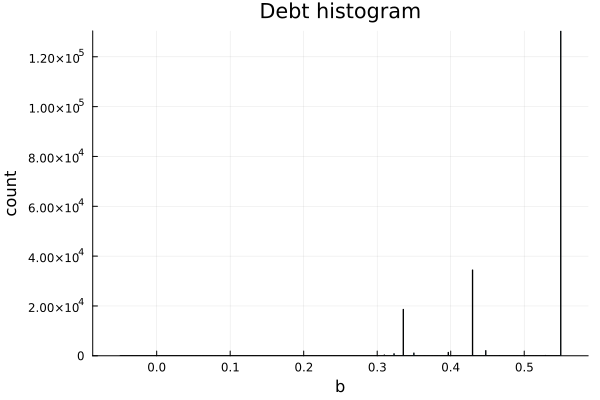

In [30]:
# Histogram of debt (b)
edges = stats.hist_edges
counts = stats.hist_counts
mid = 0.5 .* (edges[1:end-1] .+ edges[2:end])
bar(mid, counts; xlabel = "b", ylabel = "count", legend = false, title = "Debt histogram")
